In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 13 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

<img src="case2.png" width="600px">

<img src="leadlag.png" width="600px">

### 伝達関数モデル

In [26]:
P = tf([0, 10], [1, 11, 10])  # 伝達関数の記述 10/(s+1)(s+10) = 10/(s^2 + 11s + 10)
P


      10
---------------
s^2 + 11 s + 10

In [27]:
s = tf('s')
P = 10/((s+1)*(s+10))
P


      10
---------------
s^2 + 11 s + 10

### 制御対象のボード線図

-----------------
(GM, PM, wpc, wgc)
(inf, inf, nan, nan)
-----------------
2 states have been removed from the model

      10
---------------
s^2 + 11 s + 20

error= 0.5


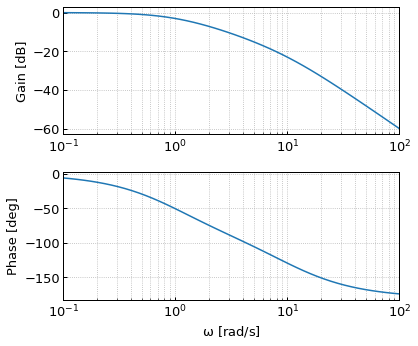

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(6,5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)  # 制御対象Pのボード線図の描画
    
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

bodeplot_set(ax)
fig.tight_layout()

print('-----------------')
print('(GM, PM, wpc, wgc)')
print(margin(P))  # ゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数

print('-----------------')
Gyr = P/(1+P)
print(minreal(Gyr))
print('error=', 1-Gyr.dcgain())  # 定常偏差

低周波ゲインが０[dB] なので，このままフィードバック系を構築しても定常偏差(=0.5)が残る．

### 設計の流れ ------------------------------------------------------

<img src="design_idea.png" width="600px">

### １．定常偏差を小さくするために，位相遅れ補償を設計する

低周波ゲインを上げるために，$\alpha=20$とする．そして，ゲインを上げる周波数は，$T_1$で決めるが，最終的なゲイン交差周波数（ゲイン交差周波数の設計値）の10分の1程度を$1/T_1$にするために，$T_1=0.5$とする（$1/T_1=20/10=2$）．

K1= 
10 s + 20
---------
10 s + 1

-----------------------
phase at 20rad/s = -155.99666022403284


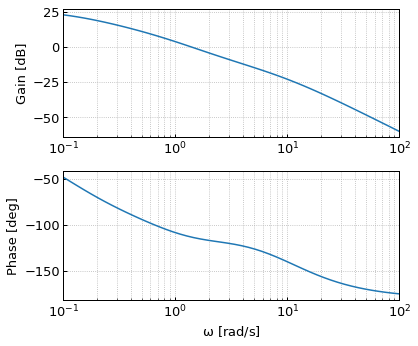

In [11]:
alpha = 20
T1 = 0.5
K1 = tf([alpha*T1, alpha], [alpha*T1, 1])  # 位相遅れ補償
print('K1=', K1)

fig, ax = plt.subplots(2, 1, figsize=(6,5)) 
H1 = P*K1
gain, phase, w = bode(H1, logspace(-1,2), Plot=False)  # 開ループ系のボード線図
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)
bodeplot_set(ax)
fig.tight_layout()

[[[mag]]], [[[phase]]], omega = freqresp(H1, [20])  # 20[rad/s]におけるゲインと位相
phaseH1at20 = phase * (180/np.pi)
print('-----------------------')
print('phase at 20rad/s =', phaseH1at20)

最終的にゲイン補償によって，ゲイン交差周波数を設計値の20[rad/s]まで上げるが，あげてしまうと，位相余裕が60[dB]を下回る．実際，20[rad/s]における位相は -155[deg]なので，位相余裕は 25[deg]程度になってしまう．したがって，20[rad/s]での位相を -120[deg] まで進ませておく．

<img src="design_idea.png" width="600px">

### 2. 位相進み補償の設計

20[rad/s]において位相を進ませる量は　60 - (180-155) = 35[deg]程度とする．

K2= 
0.09812 s + 1
-------------
0.02548 s + 1

-----------------------
gain at 20rad/s = -27.121982029204407
phase at 20rad/s = -119.99999999999999


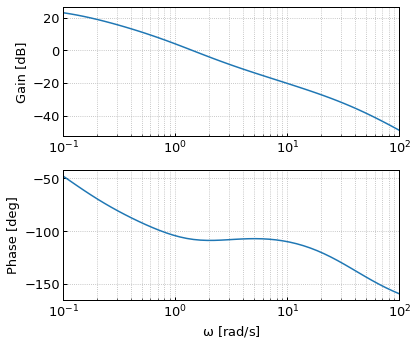

In [12]:
phim = (60- (180 + phaseH1at20 ) ) * np.pi/180
beta = (1-np.sin(phim))/(1+np.sin(phim))
T2 = 1/20/np.sqrt(beta)
K2 = tf([T2, 1],[beta*T2, 1])  # 位相進み補償
print('K2=', K2)

fig, ax = plt.subplots(2, 1, figsize=(6,5)) 
H2 = P*K1*K2
gain, phase, w = bode(H2, logspace(-1,2), Plot=False)  #開ループ系のボード線図
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)
bodeplot_set(ax)
fig.tight_layout()

[[[mag]]], [[[phase]]], omega = freqresp(H2, [20])  # 20[rad/s]におけるゲインと位相
magH2at20 = mag
phaseH2at20 = phase * (180/np.pi)
print('-----------------------')
print('gain at 20rad/s =', 20*np.log10(magH2at20))
print('phase at 20rad/s =', phaseH2at20)

位相進み補償により，20[rad/s]での位相が -120[deg]となっている．

あとは，ゲイン補償により，20[rad/s]のゲインを 0[dB] にすればよい．

### 3. ゲイン補償の設計

20[rad/s] におけるゲインが -27.12[dB] 程度なので， 27.12[dB]分上に移動させる．
そのために，$k = 1/magL2at20$ をゲイン補償とする．

k= 22.703828704125367
-----------------
(GM, PM, wpc, wgc)
(inf, 59.99999999999994, nan, 20.00000000000004)


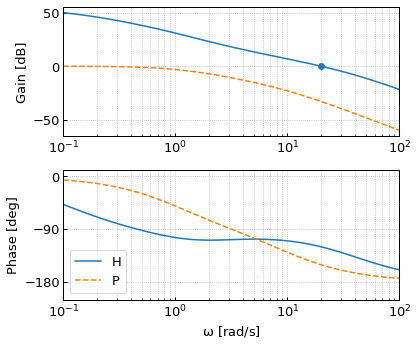

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(6,5)) 

k = 1/magH2at20  # ゲイン補償
print('k=', k)

H = P*k*K1*K2
gain, phase, w = bode(H, logspace(-1,2), Plot=False)  #開ループ系のボード線図
ax[0].semilogx(w, 20*np.log10(gain), label='H')
ax[1].semilogx(w, phase*180/np.pi, label='H')

gm, pm, wpc, wgc = margin(H) #開ループ系のゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数
ax[0].scatter(wgc,0)

gain, phase, w = bode(P, logspace(-1,2), Plot=False)  #制御対象Pのボード線図
ax[0].semilogx(w, 20*np.log10(gain), ls='--', label='P')
ax[1].semilogx(w, phase*180/np.pi, ls='--', label='P')

gm, pm, wcp, wgc = margin(P) #制御対象Pのゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数
ax[0].scatter(wgc,0)

bodeplot_set(ax, 3)
ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
fig.tight_layout()

print('-----------------')
print('(GM, PM, wpc, wgc)')
print(margin(H))

これにより，20[rad/s]がゲイン交差周波数になり，位相余裕もPM=60[deg]となる．

-----------------
開ループ伝達関数の安定性
[-39.24938213 -10.          -1.          -0.1       ]


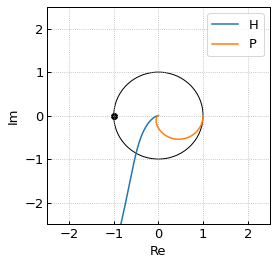

In [18]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(4,4))

x, y, _ = nyquist(H, logspace(-3,5,1000), Plot=False) # 開ループ系のナイキスト線図
ax.plot(x, y, label='H')
x, y, _ = nyquist(P, logspace(-3,5,1000), Plot=False) # 開ループ系のナイキスト線図
ax.plot(x, y, label='P')
# ax.plot(x, -y, ls='--')
ax.scatter(-1, 0, color='k')
plot_set(ax, 'Re', 'Im')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

c = patches.Circle(xy=(0, 0), radius=1, fill=False, ec='k')
ax.add_patch(c)

ax.legend()

print('-----------------')
print('開ループ伝達関数の安定性')
print(H.pole())

開ループ系は安定である．したがって，図とナイキストの安定判別より，フィードバック系は内部安定である．

### 位相進み遅れ補償

In [19]:
K = k * K1 * K2
K


22.28 s^2 + 271.6 s + 454.1
---------------------------
  0.2548 s^2 + 10.03 s + 1

### 閉ループ系のステップ応答

error= 0.0021974323816077446
------------------
error= 0.5
------------------


(0.0, 1.5)

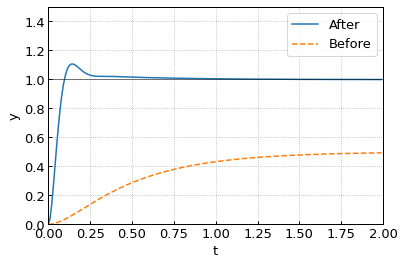

In [20]:
fig, ax = plt.subplots()

ref = 1

Gyr_H = feedback(H, 1)  # フィードバック結合
y, t = step(Gyr_H, np.arange(0,2,0.01))  # ステップ応答

ax.plot(t,y*ref, label='After')

e_std = 1 - dcgain(Gyr_H)  # 直流ゲイン
print('error=', e_std)    
print('------------------')

Gyr_P = feedback(P, 1)
y, t = step(Gyr_P, np.arange(0,2,0.01))
pltargs = {'ls': '--', 'label': 'Before'}
ax.plot(t, y*ref, **pltargs)
    
e_std = 1 - dcgain(Gyr_P)
print('error=', e_std)    
print('------------------')

ax.axhline(ref, color="k", linewidth=0.5)  
plot_set(ax, 't', 'y', 'best')
ax.set_xlim(0,2)
ax.set_ylim(0,1.5)

# fig.savefig("loop_leadlag_step.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

直流ゲイン = -0.01910765674282279
------------------
直流ゲイン = -6.020599913279624
------------------


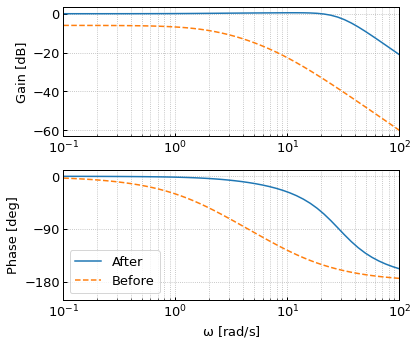

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(6,5)) 

gain, phase, w = bode(Gyr_H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='After')
ax[1].semilogx(w, phase*180/np.pi, label='After')

print('直流ゲイン =', 20*np.log10(Gyr_H.dcgain()))    
print('------------------')


gain, phase, w = bode(Gyr_P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

print('直流ゲイン =', 20*np.log10(Gyr_P.dcgain()))    
print('------------------')
    
bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("loop_leadlag_fbbode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

低周波ゲインが0[dB]に近くなり，また，バンド幅が大きくなっている